## Introduction

### In this notebook we use [UNet](https://arxiv.org/abs/1505.04597) segmentation model for performing road segmentation on [Massachusetts Roads Dataset](https://www.cs.toronto.edu/~vmnih/docs/Mnih_Volodymyr_PhD_Thesis.pdf).

### Libraries 📚⬇

In [ ]:
!pip install albumentations==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 2.0 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.1
    Uninstalling albumentations-1.3.1:
      Successfully uninstalled albumentations-1.3.1


In [ ]:
!pip install -q -U segmentation-models-pytorch albumentations

/bin/bash: line 1:  /dev/null: No such file or directory


In [ ]:
!pip install segmentation_models_pytorch==0.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 8.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_

In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [1]:
import torch

In [2]:
device = torch.cuda.is_available()
device

True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Restart kernel

In [4]:
import os
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")         #warnings module and configure it to ignore warnings. This can be helpful to suppress unnecessary warnings that might clutter the output

import torch                                                        #The top-level PyTorch package
import torch.nn as nn
from torch.utils.data import DataLoader                            #Submodule containing neural network layers, such as linear layers, convolutional layers, etc.
import albumentations as album                                    #imports the Albumentations library, which is a popular library for image augmentation in deep learning pipelines.

In [5]:
import cv2

In [6]:
import segmentation_models_pytorch as smp                 #segmentation_models_pytorch library, which is a PyTorch-based library for semantic segmentation tasks.

In [7]:
smp.losses    #This line likely accesses the submodule "metrics" within the "segmentation_models_pytorch" library, which likely contains evaluation metrics for semantic segmentation models in PyTorch.


<module 'segmentation_models_pytorch.losses' from 'c:\\Users\\dhanu\\.conda\\envs\\idk_gpu\\lib\\site-packages\\segmentation_models_pytorch\\losses\\__init__.py'>

### Defining train / val / test directories 📁

In [9]:
DATA_DIR = r'C:\Users\dhanu\Downloads\Project\data\tiff'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [11]:
class_dict = pd.read_csv(r"C:\Users\dhanu\Downloads\Project\data\label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()  #creates a list of RGB values from a DataFrame column named 'r', 'g', and 'b' within the class_dict DataFrame and converts it to a nested list.

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'road']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


#### Shortlist specific classes to segment

In [12]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'road']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'road']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


### Helper functions for viz. & one-hot encoding/decoding

In [13]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)      #cal number of image and store in n_image
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []             # empty list of sematic map
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [14]:
class RoadsDataset(torch.utils.data.Dataset):

    """Massachusetts Roads Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    def __init__(
            self,
            images_dir,
            masks_dir,
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
    ):

        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        # return length of
        return len(self.image_paths)

#### Visualize Sample Image and Mask 📈

In [15]:
dataset = RoadsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]


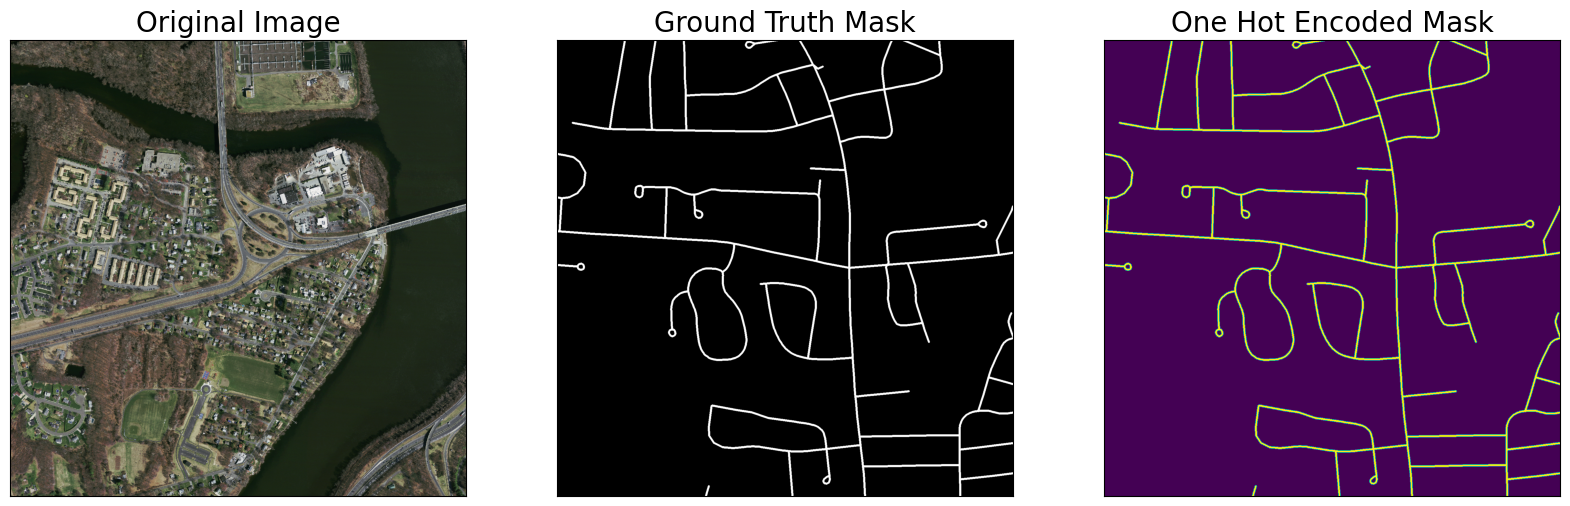

In [16]:

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

### Defining Augmentations 🙃

In [17]:
def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callable): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

#### Visualize Augmented Images & Masks

In [18]:
augmented_dataset = RoadsDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

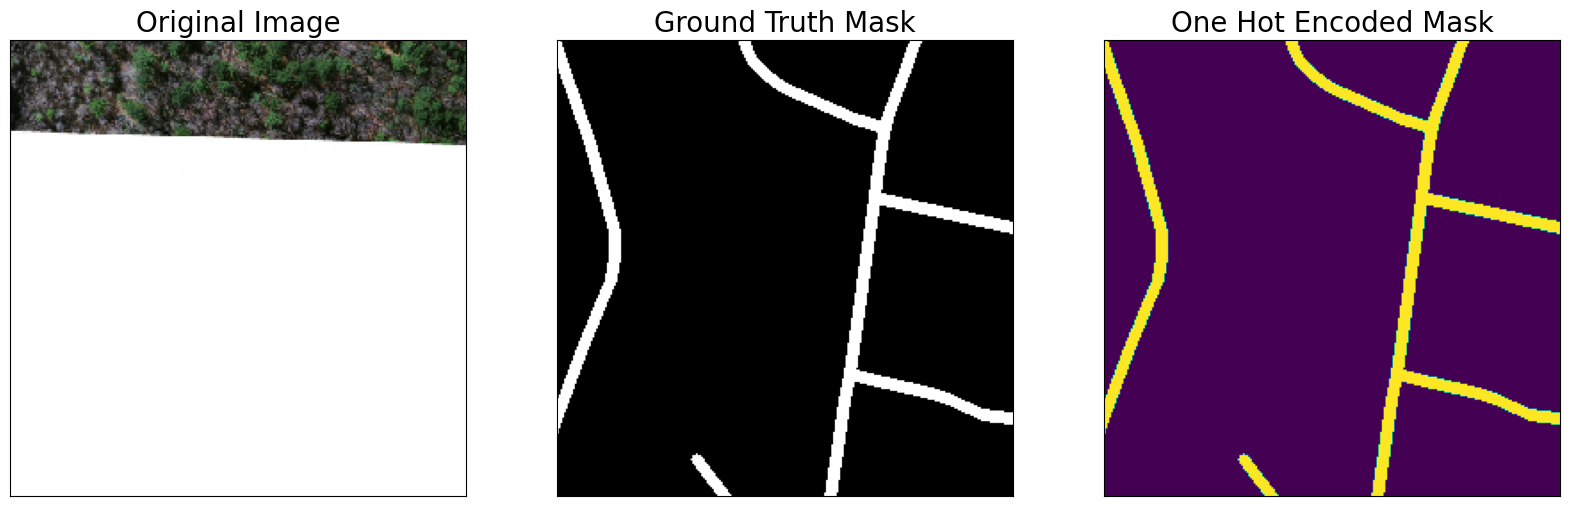

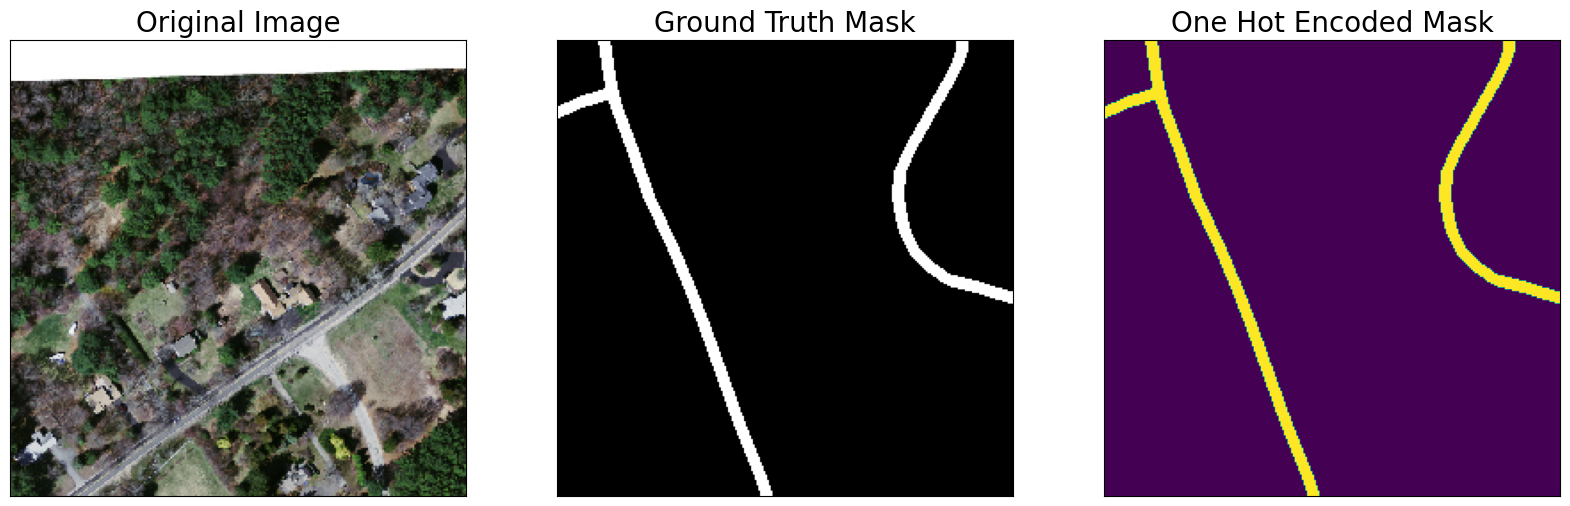

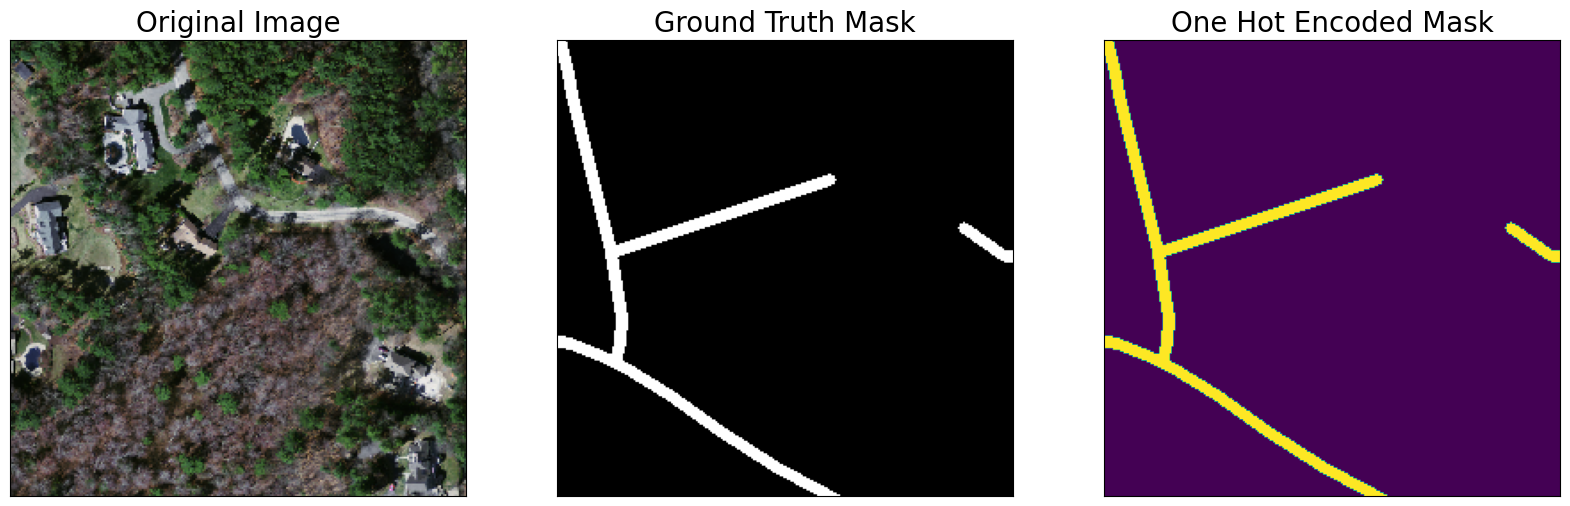

In [19]:
random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )


## Training DiResUNet
https://github.com/ggsDing/DiResNet/blob/master/models/DiResNet.py

### Model Definition

In [20]:
#An implementation of ResUNet in 'Road extraction by deep residual unet'
import torch
import torch.nn as nn
import torchvision

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

class DecBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = conv3x3(in_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.relu = nn.ReLU()

        self.identity = nn.Sequential(
                nn.BatchNorm2d(in_channels),
                conv1x1(in_channels, out_channels))

    def forward(self, x, low_feat):
        x = self.up(x)
        x = torch.cat((x, low_feat), dim=1)

        identity = self.identity(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2(x)
        return x + identity

class EncBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.relu = nn.ReLU()

        self.downsample = nn.Sequential(
                nn.BatchNorm2d(in_channels),
                conv1x1(in_channels, out_channels, stride))

    def forward(self, x):
        identity = self.downsample(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2(x)
        return x + identity

class Enc0(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.relu = nn.ReLU()

        self.identity = nn.Sequential(
                conv1x1(in_channels, out_channels, stride),
                nn.BatchNorm2d(out_channels))

    def forward(self, x):
        identity = self.identity(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        return x + identity


class ResUNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1, pretrained=True):
        super(ResUNet, self).__init__()

        self.Enc0 = Enc0(in_channels, 64)
        self.Enc1 = EncBlock(64,128)
        self.Enc2 = EncBlock(128,256)
        self.bridge = EncBlock(256, 512)

        self.Dec2 = DecBlock(512+256, 256)
        self.Dec1 = DecBlock(256+128, 128)
        self.Dec0 = DecBlock(128+64, 64)

        self.classifier = nn.Sequential(
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, num_classes, kernel_size=1))

    def forward(self, x):
        x_size = x.size()

        enc0 = self.Enc0(x)
        enc1 = self.Enc1(enc0)
        enc2 = self.Enc2(enc1)
        enc3 = self.bridge(enc2)
        dec2 = self.Dec2(enc3, enc2)
        dec1 = self.Dec1(dec2, enc1)
        dec0 = self.Dec0(dec1, enc0)

        out = self.classifier(dec0)

        return out

In [21]:
class FCN_res18a(nn.Module):
    def __init__(self, in_channels=3, num_classes=7, pretrained=False):
        super(FCN_res18a, self).__init__()
        #resnet = models.resnet18(pretrained=False)
        resnet =ResUNet(pretrained=False)
        newconv1 = conv3x3(in_channels, 64, stride=2)

        self.layer0 = nn.Sequential(newconv1, resnet.bn1, resnet.relu)
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        self.head = nn.Sequential(nn.Conv2d(512, 64, kernel_size=1, stride=1, padding=0, bias=False),
                                  nn.BatchNorm2d(64, momentum=0.95),
                                  nn.ReLU())

        self.classifier = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        x_size = x.size()

        x = self.layer0(x) #scale:1/2, 32
        x = self.layer1(x) #scale:1/2, 64
        x = self.layer2(x) #scale:1/4, 128
        x = self.layer3(x) #scale:1/8, 256
        x = self.layer4(x) #scale:1/8, 512
        x = self.head(x)
        x = self.classifier(x)

        out = F.upsample(x, x_size[2:], mode='bilinear')

        return out

In [22]:
#The direction reference data should be generated using the DirectionNet.
import torch.nn as nn
from torch.nn import functional as F
import torch
import numpy as np
#from models.FCN_8s import FCN
#from models.FCN_16s import FCN_res18a as FCN
#from models.FCN_16s import FCN_res34a as FCN
#from utils import initialize_weights

BN_MOMENTUM = 0.01

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class RefUnet(nn.Module):
    def __init__(self,in_ch):
        super(RefUnet, self).__init__()

        self.conv0 = nn.Conv2d(in_ch,in_ch,3,padding=1)

        self.conv1 = nn.Conv2d(in_ch,16,3,padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU(inplace=True)

        self.pool1 = nn.MaxPool2d(2,2,ceil_mode=True)

        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU(inplace=True)

        self.pool2 = nn.MaxPool2d(2,2,ceil_mode=True)

        self.conv3 = nn.Conv2d(32,64,3,padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU(inplace=True)

        self.pool3 = nn.MaxPool2d(2,2,ceil_mode=True)

        #####
        self.conv4 = nn.Conv2d(64,64,3,padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU(inplace=True)
        #####

        self.conv_d4 = nn.Conv2d(128,64,3,padding=1)
        self.bn_d4 = nn.BatchNorm2d(64)
        self.relu_d4 = nn.ReLU(inplace=True)

        self.conv_d3 = nn.Conv2d(128,64,3,padding=1)
        self.bn_d3 = nn.BatchNorm2d(64)
        self.relu_d3 = nn.ReLU(inplace=True)

        self.conv_d2 = nn.Conv2d(64+32,32,3,padding=1)
        self.bn_d2 = nn.BatchNorm2d(32)
        self.relu_d2 = nn.ReLU(inplace=True)

        self.conv_d1 = nn.Conv2d(32+16,16,3,padding=1)
        self.bn_d1 = nn.BatchNorm2d(16)
        self.relu_d1 = nn.ReLU(inplace=True)

        self.conv_d0 = nn.Conv2d(16,1,3,padding=1)

        self.upscore2 = nn.Upsample(scale_factor=2, mode='bilinear')


    def forward(self,x):

        hx = x
        hx = self.conv0(hx)

        hx1 = self.relu1(self.bn1(self.conv1(hx))) #scale:1
        hx = self.pool1(hx1) #scale:1/2

        hx2 = self.relu2(self.bn2(self.conv2(hx)))
        hx = self.pool2(hx2) #scale:1/4

        hx3 = self.relu3(self.bn3(self.conv3(hx)))
        hx = self.pool3(hx3) #scale:1/8

        hx4 = self.relu4(self.bn4(self.conv4(hx)))
        hx = self.upscore2(hx4)

        d3 = self.relu_d3(self.bn_d3(self.conv_d3(torch.cat((hx,hx3),1))))
        hx = self.upscore2(d3)

        d2 = self.relu_d2(self.bn_d2(self.conv_d2(torch.cat((hx,hx2),1))))
        hx = self.upscore2(d2)

        d1 = self.relu_d1(self.bn_d1(self.conv_d1(torch.cat((hx,hx1),1))))

        residual = self.conv_d0(d1)

        return x + residual

class FCN_Ref(nn.Module):
    def __init__(self, in_channels=3, num_classes=7, pretrained=True):
        super(FCN_Ref, self).__init__()
        self.FCN = FCN_res18a(in_channels, num_classes)

        self.Dec = nn.Sequential(nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2),
                                 nn.BatchNorm2d(32, momentum=BN_MOMENTUM), nn.ReLU(),
                                 nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2),
                                 nn.BatchNorm2d(16, momentum=BN_MOMENTUM), nn.ReLU(),
                                 nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=2, stride=2),
                                 nn.BatchNorm2d(16, momentum=BN_MOMENTUM), nn.ReLU())

        self.DConv = nn.Conv2d(16, 5, kernel_size=1)
        self.classifier = nn.Conv2d(16, 1, kernel_size=1)
        self.Ref = RefUnet(1)

        #initialize_weights(self.classifier, self.DConv, self.Dec, self.Ref)

    def forward(self, x):
        x_size = x.size()

        x = self.FCN_res18a.layer0(x)
        x = self.FCN_res18a.layer1(x)
        x = self.FCN_res18a.layer2(x)
        x = self.FCN_res18a.layer3(x)
        x = self.FCN_res18a.layer4(x)
        x = self.FCN_res18a.head(x)
        aux_s = self.FCN_res18a.classifier(x)

        x = self.Dec(x)

        aux_d = self.DConv(x)
        out = self.classifier(x)

        #DS = aux_d[:,1:2,:,:] + aux_d[:,2:3,:,:] + aux_d[:,3:4,:,:] + aux_d[:,4:5,:,:]
        aux_rf = self.Ref(out)

        return out, aux_s, aux_d, aux_rf

In [23]:

CLASSES = select_classes

# create segmentation model with pretrained encoder
model = RefUnet(3)



In [29]:
batch_size = 32

In [38]:
import torch
from torch.nn.modules.module import _addindent
from collections import OrderedDict
import torch.nn as nn


In [36]:
def summary(model, input_size, batch_size=-1, device=torch.device("cuda"), print_summary=True):
    result, params_info = [], OrderedDict()
    hook = lambda module, input, output: collect_info(module, input, output, params_info)
    hooks = []

    def register_hook(module):
        if (
            not isinstance(module, nn.Sequential)
            and not isinstance(module, nn.ModuleList)
            and not (module == model)
        ):
            hooks.append(module.register_forward_hook(hook))

    model.apply(register_hook)

    if isinstance(input_size, tuple):
        input_size = [input_size]

    x = [torch.rand(batch_size, *in_size).to(device) for in_size in input_size]

    try:
        with torch.no_grad():
            model(*x) if isinstance(x, list) else model(x)

    finally:
        for hook in hooks:
            hook.remove()

    if print_summary:
        print("----------------------------------------------------------------")
        line_new = "{:>20}  {:>25} {:>15}".format("Layer (type)", "Output Shape", "Param #")
        print(line_new)
        print("================================================================")
        total_params = 0
        total_output = 0
        trainable_params = 0
        for layer in params_info:
            # input_shape, output_shape, trainable, nb_params
            line_new = "{:>20}  {:>25} {:>15}".format(
                layer,
                str(params_info[layer]["output_shape"]),
                "{0:,}".format(params_info[layer]["nb_params"]),
            )
            total_params += params_info[layer]["nb_params"]
            total_output += torch.tensor(params_info[layer]["output_shape"]).prod().item()
            if "trainable" in params_info[layer]:
                if params_info[layer]["trainable"] == True:
                    trainable_params += params_info[layer]["nb_params"]
            print(line_new)

        total_input_size = abs(sum(x[0].size()) * batch_size / (1024 ** 2.0))
        total_output_size = abs(2.0 * total_output * 4.0 / (1024 ** 2.0))  # x2 for gradients
        total_params_size = total_params * 4.0 / (1024 ** 2.0)

        total_size = total_params_size + total_output_size + total_input_size

        print("================================================================")
        print(f"Total params: {total_params}")
        print(f"Trainable params: {trainable_params}")
        print(f"Non-trainable params: {total_params - trainable_params}")
        print(f"Input size (MB): {total_input_size}")
        print(f"Forward/backward pass size (MB): {total_output_size}")
        print(f"Params size (MB): {total_params_size}")
        print(f"Estimated Total Size (MB): {total_size}")
        print("----------------------------------------------------------------")

    return params_info


def collect_info(module, input, output, params_info):
    class_name = str(module.__class__).split(".")[-1].split("'")[0]
    module_idx = len(params_info)

    # Handle cases where module has no parameters
    if hasattr(module, "weight") and hasattr(module.weight, "size"):
        params = sum([p.numel() for p in module.parameters()])
        params_info[class_name + f"_{module_idx}"] = {
            "input_shape": list(input[0].size()),
            "output_shape": [-1] if output is None else list(output.size()),
            "nb_params": params,
            "trainable": any(p.requires_grad for p in module.parameters()),
        }
    else:
        params_info[class_name + f"_{module_idx}"] = {
            "input_shape": list(input[0].size()),
            "output_shape": [-1] if output is None else list(output.size()),
            "nb_params": 0,
        }



In [37]:
# summary
summary(model, (3, 224, 224), batch_size=batch_size, device=device)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d_0          [32, 3, 224, 224]              84
            Conv2d_1         [32, 16, 224, 224]             448
       BatchNorm2d_2         [32, 16, 224, 224]              32
              ReLU_3         [32, 16, 224, 224]               0
         MaxPool2d_4         [32, 16, 112, 112]               0
            Conv2d_5         [32, 32, 112, 112]           4,640
       BatchNorm2d_6         [32, 32, 112, 112]              64
              ReLU_7         [32, 32, 112, 112]               0
         MaxPool2d_8           [32, 32, 56, 56]               0
            Conv2d_9           [32, 64, 56, 56]          18,496
      BatchNorm2d_10           [32, 64, 56, 56]             128
             ReLU_11           [32, 64, 56, 56]               0
        MaxPool2d_12           [32, 64, 28, 28]               0
           Conv2d_13           [32, 64,

OrderedDict([('Conv2d_0',
              {'input_shape': [32, 3, 224, 224],
               'output_shape': [32, 3, 224, 224],
               'nb_params': 84,
               'trainable': True}),
             ('Conv2d_1',
              {'input_shape': [32, 3, 224, 224],
               'output_shape': [32, 16, 224, 224],
               'nb_params': 448,
               'trainable': True}),
             ('BatchNorm2d_2',
              {'input_shape': [32, 16, 224, 224],
               'output_shape': [32, 16, 224, 224],
               'nb_params': 32,
               'trainable': True}),
             ('ReLU_3',
              {'input_shape': [32, 16, 224, 224],
               'output_shape': [32, 16, 224, 224],
               'nb_params': 0}),
             ('MaxPool2d_4',
              {'input_shape': [32, 16, 224, 224],
               'output_shape': [32, 16, 112, 112],
               'nb_params': 0}),
             ('Conv2d_5',
              {'input_shape': [32, 16, 112, 112],
               

#### Get Train / Val DataLoaders

In [39]:
# Get train and val dataset instances
train_dataset = RoadsDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = RoadsDataset(
    x_valid_dir, y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

#### Set Hyperparams

In [45]:
from segmentation_models_pytorch import utils

In [46]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 5

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss =smp.losses.DiceLoss(mode='binary')


# define metrics
metrics = [
    #smp.losses.DiceLoss()
    smp.losses.DiceLoss,
    smp.utils.metrics.IoU(threshold=0.5)  ,
    smp.utils.metrics.Accuracy(threshold=0.5),

]

# define optimizer
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.00008),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# # load best saved model checkpoint from previous commit (if present)
# if os.path.exists('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth'):
#     model = torch.load('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth', map_location=DEVICE)

In [ ]:
#!pip show segmentation_models_pytorch

Name: segmentation-models-pytorch
Version: 0.3.3
Summary: Image segmentation models with pre-trained backbones. PyTorch.
Home-page: https://github.com/qubvel/segmentation_models.pytorch
Author: Pavel Iakubovskii
Author-email: qubvel@gmail.com
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: efficientnet-pytorch, pillow, pretrainedmodels, timm, torchvision, tqdm
Required-by: 


In [ ]:
#!pip install torch== 1.13.1 torchvision==0.14.1

In [ ]:
#!pip install segmentation_models_pytorch

In [ ]:
# import segmentation_models_pytorch as smp
# from segmentation_models_pytorch.utils.train import TrainEpoch
# from segmentation_models_pytorch.utils.train import ValidEpoch

In [ ]:
#print(smp._version_)

In [49]:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet()
loss = smp.losses.DiceLoss(mode='binary')
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Accuracy(threshold=0.5),
]
optimizer = torch.optim.Adam(model.parameters(), lr=0.00008)



In [50]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,  
    verbose=True
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,  
    verbose=True
)


In [52]:
# Example DataLoader initialization with multiprocessing disabled
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)


### Training UNet

In [54]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
train:   0%|          | 0/8 [00:06<?, ?it/s]


RuntimeError: cuDNN error: CUDNN_STATUS_MAPPING_ERROR

### Prediction on Test Data

In [ ]:
# load best saved model checkpoint from the current run
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded UNet model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth'):
    best_model = torch.load('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth', map_location=DEVICE)
    print('Loaded UNet model from a previous commit.')

In [ ]:
# create test dataloader to be used with UNet model (with preprocessing operation: to_tensor(...))
test_dataset = RoadsDataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = RoadsDataset(
    x_test_dir, y_test_dir,
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

# Notice the images / masks are 1536*1536 because of 18px padding on all sides.
# This is to ensure the input image dimensions to UNet model are a multiple of 2 (to account for pooling & transpose conv. operations).

In [ ]:
# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[1500,1500,3]):

    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    if padding<0:
        return image

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [ ]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [ ]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to road
    pred_road_heatmap = pred_mask[:,:,select_classes.index('road')]
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])

    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        predicted_road_heatmap = pred_road_heatmap
    )

### Model Evaluation on Test Dataset

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

In [ ]:
image_path = 'path/to/your/image.png'
image = Image.open(image_path).convert('RGB')  # Ensure it's in RGB model
